<a href="https://colab.research.google.com/github/Ankur-singh/personal_projects/blob/master/Notebooks/Ultimate_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Ultimate Training Loop

Writing a train loops is one of the most tedious tasks in Deep Learning. 
- It seems simple, but requires a lot of small changes in every other use-case.
- Very error prone
- It quickly becomes messy.

In this blog, I will discuss the training loop proposed by Jeremy Howard in Part 2 of the 2022 course. I think this is the last training loop that you will ever need. Its infinitely flexible and super easy to use once you get the hang of it. Lets take a look at it. 

**Disclaimer:** Most of the code snippets and ideas used in this blog are taken from fastai. So, credit for everything good should go to Jeremy Howard, and everything bad or mediocre is my work. The main reason for writing the blog was to consolidate my learning.

## Setting Up

I will start by writing all the necessary code. Its okay if you don't understand it completely. In fact, even I am exploring. But don't worry, I will try my best to highlight and explain the code snippets that are important to understanding this blog. The main focus of this blog is to get you excited about this training loop and show you "how to use it" through examples.

In [ ]:
import torch
import fastcore.all as fc
from torch import nn, optim
from functools import partial
from operator import attrgetter
from torch.nn import functional as F

In [ ]:
# Callback Utilities

class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

class Callback(): order = 0

def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In the above cell, we defined three custom exceptions, namely `CancelFitExeption`, `CancelBatchException`, and `CancelEpochException`. We will be raising them to cancel different parts of our training loop. 

Next, we defined a `Callback` class and `run_cbs` function. The `run_cbs` function is quite interesting. It takes a *list of callbacks*, a *method name*, and a *learner object* as input. 

We start by sorting our callbacks based on `order` (hence, the `Callback` class has a static variable named `order`). Then, for each callback in the sorted list if the particular method is present, then it will be called with *learner* as an argument. 

In [ ]:
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

The `with_cbs` class is a super compact way of defining a decorator that returns a new function wrapping `learn.callback("before_<context_name>")` and `learn.callback("after_<context_name>)` calls around the main function. Furthermore, its put in a *try-except-finally* block that handles `Cancel<Context_name>Exception` and runs `cleanup_<context_name>` methods in the finally block.

In [ ]:
# Main Training Loop

class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

 The above code might look daunting so here is a simplified version of it.

```python
def one_epoch(self, train):
    self.model.train(train)
    self.dl = self.dls.train if train else self.dls.valid
    self.callback('before_epoch')             # Epoch start
    for self.iter,self.batch in enumerate(self.dl):
        self.callback('before_batch')         # Batch Start
        self.predict()
        self.callback('after_predict')        # After populating self.preds
        self.get_loss()
        self.callback('after_loss')           # After calculating self.loss
        if self.training:
            self.backward()
            self.callback('after_backward')  # After calling backward
            self.step()
            self.callback('after_step')      # After performing weight updates
            self.zero_grad()
        self.callback('after_batch')         # Batch End
    self.callback('after_epoch')             # Epoch End


def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None)
    self.n_epochs = n_epochs
    self.epochs = range(n_epochs)
    if lr is None: lr = self.lr
    if self.opt_func: 
        self.opt = self.opt_func(self.model.parameters(), lr)
    self.callback('before_fit')              # Fit Start
    for self.epoch in self.epochs:
        if train: self.one_epoch(True)
        if valid: torch.no_grad()(self.one_epoch)(False)
    self.callback('after_fit')               # Fit End


```

There are two interesting things in this training loop:
1. It doesn't have implementation for `predict`, `get_loss`, `backward`, `step`, and `zero_grad` methods. So, one can easily inherit this learner class and implement these methods based on one's use-case. We will discuss this in more detail in a minute. 
2. It supports callbacks at various stages of the training process like `before_fit`, `after_fit`, `before_epoch`, so on and so forth. This will allow us to run arbitrary code at any of these various points in the training loop. I have highlighted all these points in the above code snippet.

Both these features might look very simple at first, but trust me its very powerful. I will be discussing both the features and their applications in detail so hold on tight. Its going to be fun!

But before we can test this loop, we will need some data and a model, right? I plan to keep it simple so that we can focus on the topic at hand. When it comes to keeping things simple, whats better than *fashion_mnist* and basic CNN?

In [ ]:
from torchvision import transforms as T
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [ ]:
BS = 64

tfms = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])

train_ds = FashionMNIST('./data', train=True, transform=tfms, download=True)
test_ds = FashionMNIST('./data', train=False, transform=tfms, download=True)

train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BS, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Its much easier if we put both the dataloaders together in a single object. So, lets make a very simple class for this.

In [ ]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

In [ ]:
dls = DataLoaders(train_dl, test_dl)
dls.train, dls.valid

(<torch.utils.data.dataloader.DataLoader at 0x7f0106396ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f01040c9d90>)

Perfect, we have our data in place. Next, we need to build our model. We will build a very simple CNN model

In [ ]:
def get_model():
    return nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(),
                      nn.Conv2d(8, 16, 3), nn.ReLU(),
                      nn.Conv2d(16, 32, 3), nn.ReLU(),
                      nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                      nn.Linear(32, 10))

model = get_model()
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=32, out_features=10, bias=True)
)

One last thing, our loss function

In [ ]:
loss_func = nn.CrossEntropyLoss()

I am cheating a bit by using a callback even though I have not discussed it. But bear with me, it will all make sense when we will talk about callbacks. For now, just think of it as a class responsible for tracking metrics and loss, and also printing them after each epoch.

In [ ]:
!pip install -q torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 KB 2.5 MB/s eta 0:00:00


In [ ]:
from copy import copy
from collections.abc import Mapping
from torcheval.metrics import MulticlassAccuracy, Mean

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())

Now we are all set to test our training loop. I will start by discussing the first feature in detail, followed by the second feature.

## Inheriting Learner

The very first thing that we should do is define `predict`, `get_loss`, `backward`, `step`, and `zero_grad` methods so that we can train our CNN model on our dataset.

To accomplish this, we can simply inherit the `Learner` class and implement these method as follows:

In [ ]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])   # batch -> (x, y)
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

As you can see, all our methods are so concise and to the point. Lets train our model.

In [ ]:
learner = TrainLearner(get_model(), dls, cbs=metrics, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.400', 'loss': '1.572', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.544', 'loss': '1.086', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.651', 'loss': '0.945', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.636', 'loss': '0.960', 'epoch': 1, 'train': 'eval'}


This `TrainLearner` class can now be used to train any model on any dataset if you have a simple training loop. But what if you have a more complex training loop? Easy! just update the corresponding method implementation.

For example, you want to introduce *momentum*

In [ ]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    
    def zero_grad(self):
        for p in self.model.parameters():
            p.grad *= self.mom

We will start by inheriting the `TrainLearner` class. We will update the `__init__` method to take an extra parameter (`mom`). Next, we just need to update the `zero_grad` method to multiply all the gradients with `self.mom` instead of zeroing them. 

In [ ]:
learner = MomentumLearner(get_model(), dls, cbs=metrics, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.561', 'loss': '1.162', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.707', 'loss': '0.932', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.735', 'loss': '0.738', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.754', 'loss': '0.681', 'epoch': 1, 'train': 'eval'}


Hurry! we jumped from ~65% accuracy to ~75% just by adding momentum. And also the loss is much lower.

One can already appreciate how easy it was to add momentum to our learner. Things get even more exciting once you start using callbacks to run code at other stages of the training loop. 

## Callbacks

Callbacks are pretty widely used in programming. They basically allow you to inject and run arbitrary code in your program. One can pass functions as variables to other functions in Python. Hence, using callbacks in python feels very natural.

We will start by building some simple callbacks and gradually build our way to more advanced callbacks.

### Single Batch & Epoch Callback

Lets write a basic callback that will stop the training after one batch. To stop the training after one batch, you can just raise `CancelFitException` after batch. Heres the code

In [ ]:
class SingleBatchCB(Callback):
    def after_batch(self, learner): 
        print('[SingleBatchCB] Terminating . . . ')
        raise CancelFitException()

Its pretty straight forward. Lets see it in action.

In [ ]:
cbs = [metrics, SingleBatchCB()]
learner = MomentumLearner(get_model(), dls, cbs=cbs, loss_func=loss_func)
learner.fit(2)

[SingleBatchCB] Terminating . . . 


The training terminates immediately even after calling `fit()` with 2 epochs.

Similarly, heres the code for `SingleEpochCB`

In [ ]:
class SingleEpochCB(Callback):
    def after_epoch(self, learner): 
        if not learner.model.training:
            print('[SingleEpochCB] Terminating . . . ') 
            raise CancelFitException()

Here, we have one extra thing. Both training and validation are epochs. To differentiate them, we can use the `learner.model.training` attribute. In the above cell, we will only raise exception if its a validation epoch.

In [ ]:
cbs = [metrics, SingleEpochCB()]
learner = MomentumLearner(get_model(), dls, cbs=cbs, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.597', 'loss': '1.076', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.678', 'loss': '0.873', 'epoch': 0, 'train': 'eval'}
[SingleEpochCB] Terminating . . . 


So, our training terminates after one epoch. You can see the loss printed after both training and validation.  

Both these callbacks can be used to quickly test if the code is working properly or not. Minor errors like dimension mismatch, incorrect data types, etc can be caught very easily. Furthermore, these callbacks can be used in scenarios where you have to do a forward pass like looking at the model summary. We will be implementing a summary callback toward the end of this notebook.

### Device and Channel Last Callback

The training is pretty slow on CPU. So lets write a callback that would move our model and batch to GPU.

In [ ]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCB(Callback):
    def __init__(self, device=def_device): self.device=device
    def before_fit(self, learn): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, self.device)

`DeviceCB` simply moves the *model* to device *before_fit*, and moves the *batch* to device *before_batch*.

In [ ]:
cbs = [metrics, DeviceCB()]
learner = MomentumLearner(get_model(), dls, cbs=cbs, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.587', 'loss': '1.106', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.765', 'loss': '0.715', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.770', 'loss': '0.656', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.791', 'loss': '0.615', 'epoch': 1, 'train': 'eval'}


This time around, the training was much quicker. We can make the training even faster by using *channel last* memory format. You can read more about it [here](https://pytorch.org/blog/accelerating-pytorch-vision-models-with-channels-last-on-cpu/). Lets write a callback for that



In [ ]:
class ChannelLastCB(Callback):
    def before_fit(self, learn): learn.model = learn.model.to(memory_format=torch.channels_last)
    def before_batch(self, learn): learn.batch[0] = learn.batch[0].contiguous(memory_format=torch.channels_last)

In [ ]:
cbs = [metrics, ChannelLastCB(), DeviceCB()]
learner = MomentumLearner(get_model(), dls, cbs=cbs, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.600', 'loss': '1.065', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.738', 'loss': '0.719', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.763', 'loss': '0.659', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.785', 'loss': '0.606', 'epoch': 1, 'train': 'eval'}


As you can see its so easy to introduce new ideas. We can write a callback for each new idea and pass them all to our learner. Once you start working with multiple callbacks it becomes quite powerful.

### TrainCB

Earlier we inherited the `Learner` class to define `TrainLearner`. We can also implement the same using callbacks. 

Here is a `TrainCB` that will define `predict`, `get_loss`, `backward`, `step`, and `zero_grad` methods for training

In [ ]:
class TrainCB(Callback):
    def predict(self, learn): learn.preds = learn.model(learn.batch[0])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, learn.batch[1])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

Now we can pass this callback to our `Learner` class, not `TrainLearner`, to start training.

In [ ]:
cbs = [TrainCB(), metrics, DeviceCB()]
learner = Learner(get_model(), dls, loss_func=loss_func, cbs=cbs)
learner.fit(2)

{'accuracy': '0.391', 'loss': '1.637', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.519', 'loss': '1.208', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.633', 'loss': '0.983', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.628', 'loss': '0.927', 'epoch': 1, 'train': 'eval'}


This callback highlights one very important insight. Even though, `predict` and other methods are not defined in the `Learner` class its able to use the `predict` method from the callback. 

The `Learner` class first checks for `predict` method inside `self`, if no `predict` method is found then it will search for it inside callbacks. Error is only raised when there is no `predict` method in any callback.

Lets introduce more ideas using callbacks

### Gradient Accumulation & Clipping Callback

Next, we will write a callback for [gradient clipping](https://stackoverflow.com/a/56069467). Just like all above callbacks, it would not be more than a single line of code

In [ ]:
class GradientClippingCB(Callback):
    def __init__(self, max_norm=1.0, norm_type=2): 
        self.max_norm, self.norm_type = max_norm, norm_type
        
    def after_backward(self, learner):
        torch.nn.utils.clip_grad_norm_(learner.model.parameters(), self.max_norm, self.norm_type)

Ever heard about Gradient Accumulation? This technique allows you to train models with large batch size even when your GPU can hold only a few samples before it runs out of memory.

You can read more about it in [this blog](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255). Here is a short excert from the blog to give you a gist of how its done.
> Accumulating gradients just means that, before calling `optimizer.step()` to perform a step of gradient descent, we will sum the gradients of several backward operations in the `parameter.grad` tensors. This is straightforward to do in PyTorch as the gradient tensors are not reset unless we call `model.zero_grad()` or `optimizer.zero_grad()`. We’ll also need to divide by the number of accumulation steps if our loss is averaged over the training samples.

In [ ]:
class GradientAccumulationCB(Callback):
    def __init__(self, n): 
        self.counter = 0
        self.n = n

    def after_loss(self, learner):
        learner.loss = learner.loss / self.n
        
    def after_backward(self, learner):
        self.counter += 1
        if self.counter % self.n != 0:
            raise CancelBatchException()

In the `after_backward()` method we are only zeroing the gradient when `self.counter` is divisible by `self.n`. At other times, we are just raising the `CancelBatchException` exception so neither `self.step()` nor `self.zero_grad()` methods are executed.

But there is one shuttle problem with this callback. What if you have 19 batches in total and we are accumulating gradients every 5 batches? Clearly, the gradients will be accumulated in the last 4 batches but weights will not be updated.

How do you fix this? Simple, call `self.step()` and `self.zero_grad()` after each training epoch. Here is the updated code

In [ ]:
class GradientAccumulationCB(Callback):
    def __init__(self, n): 
        self.counter = 0
        self.n = n

    def after_loss(self, learner):
        learner.loss = learner.loss / self.n
        
    def after_backward(self, learner):
        self.counter += 1
        if self.counter % self.n != 0:
            raise CancelBatchException()

    def after_epoch(self, learner):
        if learner.model.training: 
            learner.step()
            learner.zero_grad()

Lets train our model with both gradient clipping and accumulation.

In [ ]:
cbs = [metrics, ChannelLastCB(), DeviceCB(), GradientClippingCB(), GradientAccumulationCB(2)]
learner = MomentumLearner(get_model(), dls, cbs=cbs, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.469', 'loss': '0.710', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.542', 'loss': '0.657', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.660', 'loss': '0.465', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.598', 'loss': '0.555', 'epoch': 1, 'train': 'eval'}


it would be exciting to see if we can train the model with a large learning rate

### Mixed Precision Training

Lets implement mixed precision training. For details, refer [this pytorch tutorial](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html)

In [ ]:
class MixedTrainingCB(Callback):
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()
    def before_batch(self, learn):
        self.autocast = torch.autocast('cuda', dtype=torch.float16)
        self.autocast.__enter__()
    def after_loss(self, learn):
        self.autocast.__exit__(None, None, None)
    def backward(self, learn): self.scaler.scale(learn.loss).backward()
    def step(self, learn): 
        self.scaler.step(learn.opt)
        self.scaler.update()

In [ ]:
cbs = [metrics, DeviceCB(), MixedTrainingCB()]
learner = MomentumLearner(get_model(), dls, cbs=cbs, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.599', 'loss': '1.071', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.748', 'loss': '0.701', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.779', 'loss': '0.617', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.813', 'loss': '0.534', 'epoch': 1, 'train': 'eval'}


There's an even easier way to implement mixed precision training using the `accelerate` python package. Its pretty simple to integrate 

In [ ]:
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 16.3 MB/s eta 0:00:00


In [ ]:
from accelerate import Accelerator

In [ ]:
class AccelerateCB(TrainCB):
    def __init__(self, mixed_precision="fp16"):
        super().__init__()
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss)

Note that we are inheriting from `TrainCB` instead of `Callback` because we are updating the `backward` method. Hence, we will be using `Learner` and not `TrainLearner` or `MomentumLearner` class for training.

In [ ]:
cbs = [metrics, DeviceCB(), AccelerateCB()]
learner = Learner(get_model(), dls, cbs=cbs, loss_func=loss_func)
learner.fit(2)

{'accuracy': '0.341', 'loss': '1.761', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.557', 'loss': '1.285', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.647', 'loss': '0.964', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.692', 'loss': '0.887', 'epoch': 1, 'train': 'eval'}


You might have already realized the power of this callback feature. The most important part is isolation. When you are implementing some feature or research paper, you can just focus on the feature at hand. Everything else will just work. This highly reduces the chances of error, and also increases the speed of experimentation. 

### LR Finder

Lets build the iconic `lr_find()`. The idea is to train the model with growing learning rates until the current loss becomes greater than some multiple of minimum loss. Here, we will use 3 as the multiple. Then plots the losses vs the learning rates with a log scale.

In [ ]:
import math
import matplotlib.pyplot as plt

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): 
        self.lr_mult = lr_mult
    def before_fit(self, learn): 
        self.lrs, self.losses = [], []
        self.min = math.inf
    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

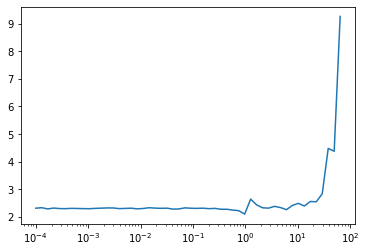

In [ ]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, lr=1e-4, cbs=cbs, loss_func=loss_func)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

Doing this every time, is quite a tedious job. So, lets create a learner method. 

The amazing thing is that you can pass callbacks to our `fit()` method as well. The fit method will automatically remove the callback after training is complete.

In [ ]:
@fc.patch
def lr_find(self:Learner, lr_mult=1.3, start_lr=1e-5, max_epochs=10):
    lrfind = LRFinderCB(lr_mult=lr_mult)
    self.fit(max_epochs, lr=start_lr, cbs=lrfind)
    plt.plot(lrfind.lrs, lrfind.losses)
    plt.xscale('log')

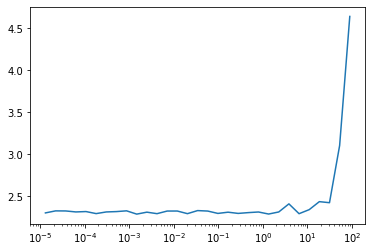

In [ ]:
learner = MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs)
learner.lr_find()

Now we are talking. This is such a handy API to quickly find the right learning rate.

By this time, you should have realized how powerful these callbacks can get. I know this is very new for a lot of people and will take some getting used to. To build your muscle try reading the `MetricsCB` that we have defined at the very beginning of this notebook.

Another thing that one can try is to go through the Fastai Callbacks docs and try reading them all. This will give you a pretty good idea about all the different things that can be accomplished using callbacks. You can even try reading the source code. The syntax is a bit different but still it would be good practice. 

## Order of Callbacks

One caveat when using multiple callbacks is the order of execution. For all particular events like `after_loss` all the callbacks that define these methods will be executed. So, if there are 4 callbacks that define the `after_loss` method then all of them will be executed. But what if one of them raises `CancelFitException`? Its will cancel the complete training and other methods will not be executed. Hence, the order in which they are executed is really important.  

Here are examples to substantiate the idea. For example, you want to use `SingleEpochCB` and `MetricsCB` together. Both of them define the `after_epoch` method. The `after_epoch` method in `SingleEpochCB` simply raises `CancelFitException`. Its really important that `MetricsCB` is executed before `SingleEpochCB`. Else, loss and other metrics will not be aggregated or logged. 

Here is an example, first we will execute `SingleEpochCB`

In [ ]:
cbs = [SingleEpochCB(), metrics, DeviceCB()] # important
learner = MomentumLearner(get_model(), dls, loss_func=loss_func, cbs=cbs)
learner.fit(3)

{'accuracy': '0.584', 'loss': '1.111', 'epoch': 0, 'train': 'train'}
[SingleEpochCB] Terminating . . . 


Here, only training metrics are logged because in validation loop `SingleEpochCB` callback is executed first that terminates the training. Next, we will change the order of callbacks

In [ ]:
cbs = [metrics, SingleEpochCB(), DeviceCB()] # update
learner = MomentumLearner(get_model(), dls, loss_func=loss_func, cbs=cbs)
learner.fit(3)

{'accuracy': '0.584', 'loss': '1.111', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.744', 'loss': '0.726', 'epoch': 0, 'train': 'eval'}
[SingleEpochCB] Terminating . . . 


As you can see both training and validation metrics are logged. Validation metrics are only logged when `MetricsCB` is executed before `SingleEpochCB()`. But this approach of changing the callbacks order in the list is not very useful if you don't know the internal workings of the callback. Also, it introduces an element of uncertainty in the code. So, we need a better mechanism to better handle the order of execution.

If you might have noticed, the `Callback` class has an attribute called `order`. `run_cbs` function sorts all the callbacks based on this `order` attribute. So, if you want some callback to be executed before others then make sure its `order` is less than others. And if you want to execute last, then make its order really large.

Lets update our `SingleEpochCB` so that its executed last everytime.

In [ ]:
class SingleEpochCB(Callback):
    order = Callback.order + 1  # update
    def after_epoch(self, learner): 
        if not learner.model.training:
            print('[SingleEpochCB] Terminating . . . ') 
            raise CancelFitException()

After this single line of change, no matter the order of `SingleEpochCB` in the list, it will always be executed after `MetricsCB`.

In [ ]:
cbs = [SingleEpochCB(), metrics, DeviceCB()] # important
learner = MomentumLearner(get_model(), dls, loss_func=loss_func, cbs=cbs)
learner.fit(3)

{'accuracy': '0.519', 'loss': '1.297', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.719', 'loss': '0.767', 'epoch': 0, 'train': 'eval'}
[SingleEpochCB] Terminating . . . 


Even though `SingleEpochCB` comes before `MetricsCB` in the `cbs` list, it is executed after `MetricsCB`. 

**Note:** I must admit, this is the most error prone aspect of this approach. Even if there is an error, its difficult to detect and debug because of multiple levels of abstraction. Often I add `print` statements to check if things are working as expected.

Generally the idea is to execute the callbacks that raise exceptions towards the end. But there can be some scenarios where this is not true. So, it  depends on the use-case.

## Summary

Here are some of the most important takeaways:

- Base `Learner` class doesn't have `predict`, `get_loss`, `backward`, `step`, and `zero_grad` methods defined. You can implement these methods either by inheriting the `Learner` class or by using callbacks.
- Using callbacks, you can inject arbitrary code at various points inside the training loop.
- The order of callbacks is extremely important when passing multiple callbacks.
- You can also pass callbacks to the `fit()` method. These callbacks are automatically removed after that training loop.


You can accomplish much more when you combine Callbacks with Pytorch Hooks. In the next blog, we will be discussing Hooks in detail and will write some amazing callbacks. Until next time 👋